*IMPORTS*

In [1]:
# type: ignore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

*EXPLORATORY DATA ANALYSIS*

In [3]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


<AxesSubplot:xlabel='Churn', ylabel='count'>

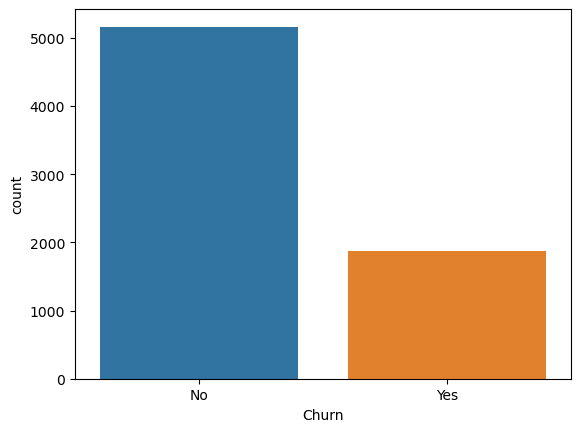

In [6]:
sns.countplot(x='Churn',data=df)

In [7]:
sns.scatterplot(data=df,x='MonthlyCharges',y='TotalCharges',hue='Churn',linewidth=0.1,alpha=0.8)

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

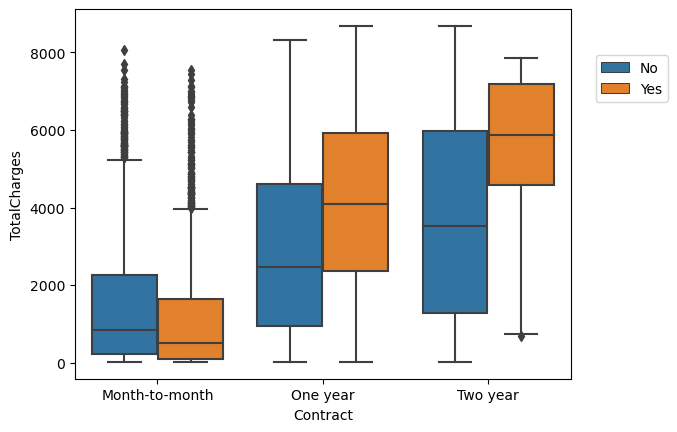

In [8]:
sns.boxplot(y='TotalCharges',x='Contract',data=df,hue='Churn')
plt.legend(loc=(1.05,0.75))

<AxesSubplot:xlabel='Contract', ylabel='count'>

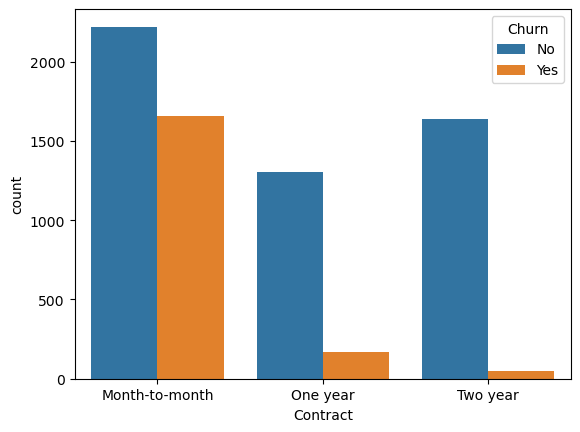

In [9]:
sns.countplot(x='Contract',hue='Churn',data=df)

# Neural Network Model

Convert categorical fields to numeric for use in Neural Network.  **DISCLAIMER:** This may introduce inherent 'data loss' as the context and relative comparibility of categorical data is being converted to quantitative data which has concrete comparibility. We assume here that the conversion does not cause significant data loss in this context.


In [4]:

dummied_df = pd.get_dummies(df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod','Churn']])
      

Explore correlations of features to 'Churn_Yes' column

In [5]:
churn_corr = dummied_df.corr()['Churn_Yes'].sort_values(ascending=False).iloc[1:-1]
churn_corr

Contract_Month-to-month                    0.404565
OnlineSecurity_No                          0.342235
TechSupport_No                             0.336877
InternetService_Fiber optic                0.307463
PaymentMethod_Electronic check             0.301455
OnlineBackup_No                            0.267595
DeviceProtection_No                        0.252056
PaperlessBilling_Yes                       0.191454
Dependents_No                              0.163128
SeniorCitizen                              0.150541
Partner_No                                 0.149982
StreamingMovies_No                         0.130920
StreamingTV_No                             0.128435
StreamingTV_Yes                            0.063254
StreamingMovies_Yes                        0.060860
MultipleLines_Yes                          0.040033
PhoneService_Yes                           0.011691
gender_Female                              0.008545
gender_Male                               -0.008545
MultipleLine

Text(0, 0.5, 'Correlation')

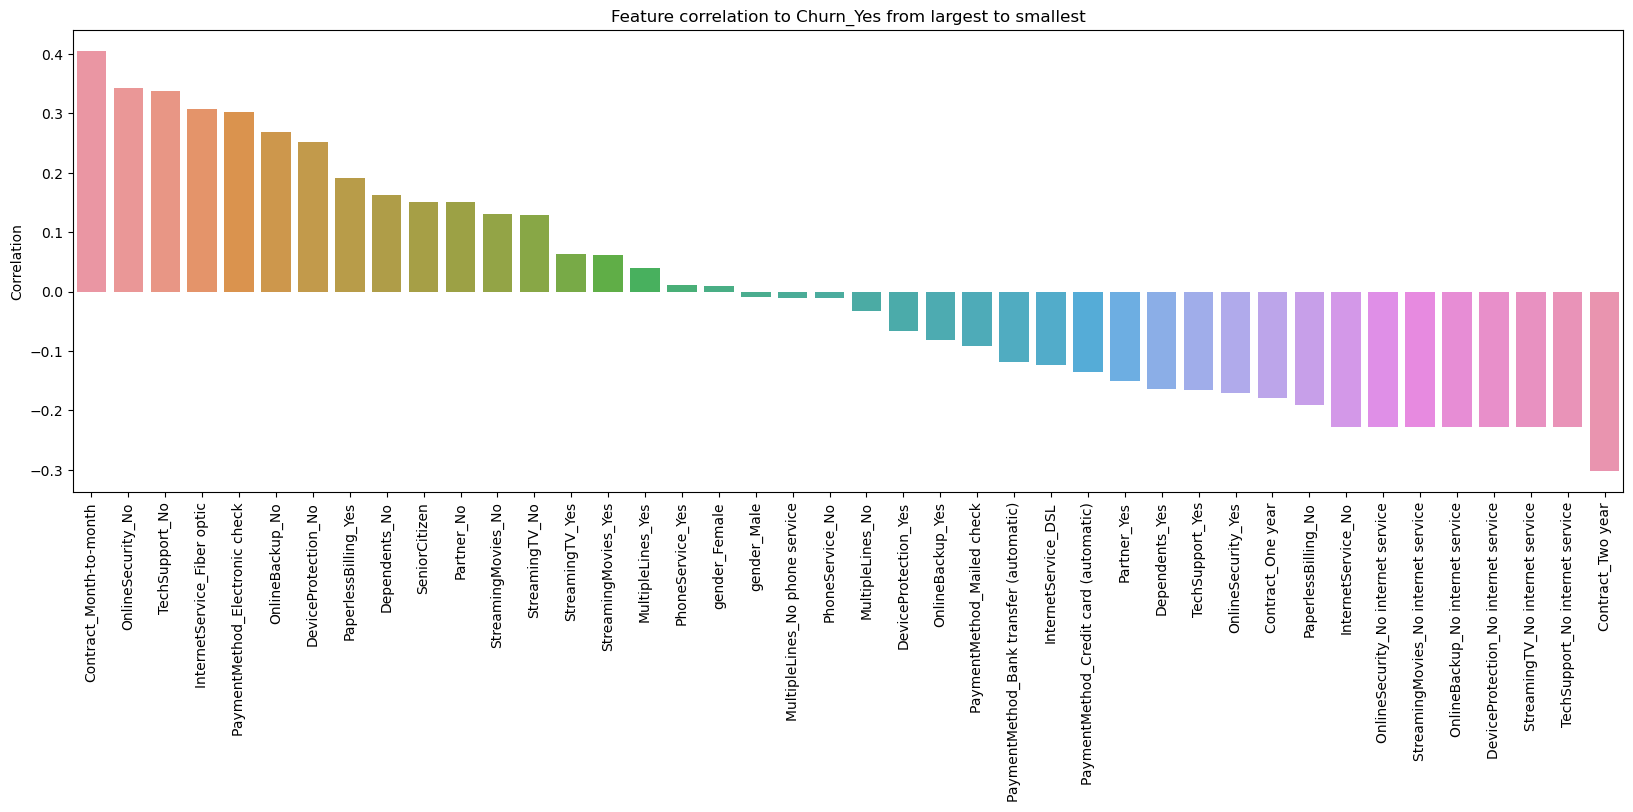

In [6]:
plt.figure(figsize=(20,6))
sns.barplot(x=churn_corr.index, y=churn_corr.values)
plt.xticks(rotation=90);
plt.title('Feature correlation to Churn_Yes from largest to smallest')
plt.ylabel('Correlation')

Contract Type (Month-Month, One Year, Two Year) has highest positive AND negative correlation to Churn, as indicated by figure above.

# Model implementation

In [8]:
# type: ignore

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

In [9]:
# drop target column, unique ID column and create dummy variables for categorical features 
# and drop_first to reduce nr of features (duplicated dummy info)
X = pd.get_dummies(df.drop(['Churn','customerID'],axis=1),drop_first=True) 
# define target column
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=17)

# MLP is sensitive to feature scaling, so we scale training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Base Model

In [13]:
base_model = MLPClassifier(random_state=1,max_iter=500).fit(X_train,y_train)


              precision    recall  f1-score   support

          No       0.85      0.85      0.85       784
         Yes       0.57      0.56      0.56       271

    accuracy                           0.78      1055
   macro avg       0.71      0.71      0.71      1055
weighted avg       0.78      0.78      0.78      1055



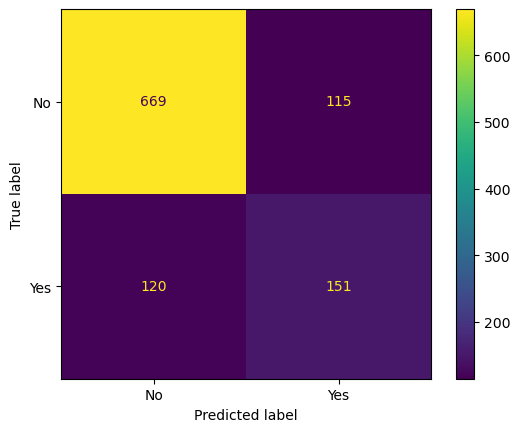

In [14]:
print(classification_report(y_test, base_model.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(base_model,X_test,y_test)

As the report shows, for our base model, predicting 'Yes' for customer churn has an f1-score of only 56. Hence we try improve our base model parameters by a performing a parameter grid search.

In [15]:
from sklearn.model_selection import GridSearchCV

nr_features = len(X.columns)

param_space = {
    'hidden_layer_sizes':[(nr_features,15,5),((2*nr_features)-1,25,15,5),((2*nr_features)-1,)],
    'activation':['logistic','tanh','relu'],
    'solver':['lbfgs','sgd','adam'],
    'alpha':[0.0001,0.05],
    'learning_rate':['constant','invscaling','adaptive'],
}

initial_model = MLPClassifier(random_state=1,max_iter=500)

grid_model = GridSearchCV(initial_model,param_space,n_jobs=-1)


In [30]:
grid_model.fit(X_train,y_train)

GridSearchCV(estimator=MLPClassifier(max_iter=500, random_state=1), n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(30, 15, 5), (59, 25, 15, 5),
                                                (59,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [35]:
grid_model.best_estimator_

MLPClassifier(activation='logistic', alpha=0.05, hidden_layer_sizes=(59,),
              max_iter=500, random_state=1)

In [37]:
grid_model.best_params_

{'activation': 'logistic',
 'alpha': 0.05,
 'hidden_layer_sizes': (59,),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [34]:
best_CV_model = grid_model.best_estimator_

              precision    recall  f1-score   support

          No       0.86      0.88      0.87       784
         Yes       0.63      0.58      0.60       271

    accuracy                           0.80      1055
   macro avg       0.74      0.73      0.74      1055
weighted avg       0.80      0.80      0.80      1055



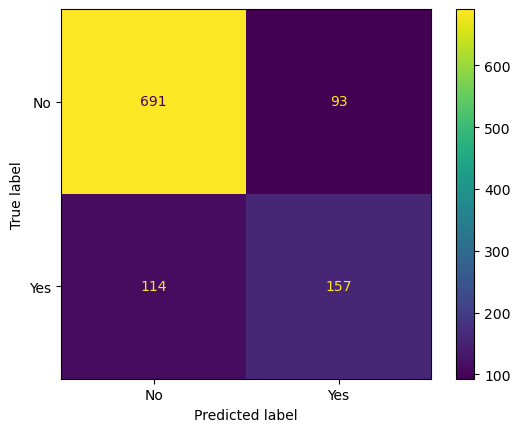

In [36]:
print(classification_report(y_test, best_CV_model.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(best_CV_model,X_test,y_test)

Since the Churn 'Yes' prediction f1-score has improved to only 60 (from 56) we attempt to improve by expanding on the alpha paramater.

In [16]:
param_space = {
    'hidden_layer_sizes':[((2*nr_features)-1,)],
    'activation':['logistic'],
    'solver':['adam'],
    'alpha':[0.05,0.5],
    'learning_rate':['constant'],
}

alpha_model = GridSearchCV(initial_model,param_space,n_jobs=-1)
alpha_model.fit(X_train,y_train)


GridSearchCV(estimator=MLPClassifier(max_iter=500, random_state=1), n_jobs=-1,
             param_grid={'activation': ['logistic'], 'alpha': [0.05, 0.5],
                         'hidden_layer_sizes': [(59,)],
                         'learning_rate': ['constant'], 'solver': ['adam']})

In [17]:
alpha_model.best_params_

{'activation': 'logistic',
 'alpha': 0.05,
 'hidden_layer_sizes': (59,),
 'learning_rate': 'constant',
 'solver': 'adam'}

Since the alpha parameter found by cross-validation is still 0.05, we may conclude this is the best performance for our MLP model with the above specified parameters and number of dimensions. We further try to improve our model by reducing the number of dimensions in our dataset. For this we explore, firstly, multi-collinearity.

# Feature Selection

Investigate correlations:

In [11]:
corr_df = pd.get_dummies(df.drop(['customerID'],axis=1),drop_first=True)

#Generate a mask for upper triangle
corr = corr_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(12, 6),dpi=200)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='viridis',xticklabels=True, yticklabels=True,cbar_kws={"shrink": .5})

<AxesSubplot:>

In [29]:
corr_df.shape

(7032, 31)

# Multicollinearity Check

Drop highly correlated feature to try and improve accuracy/efficiency of model using variance inflation factor


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(corr_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

# apply VIF computation to all columns
features = corr_df.drop(columns=["Churn_Yes"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

In [ ]:
# drop with highest vif score until all vif scores are under 20
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

In [20]:
vif_data

feature        VIF
0                           SeniorCitizen   1.370189
1          MultipleLines_No phone service   1.511932
2   PaymentMethod_Credit card (automatic)   1.739492
3              PaymentMethod_Mailed check   1.804537
4                             gender_Male   1.904879
5                      OnlineSecurity_Yes   1.940337
6                          Dependents_Yes   1.954438
7                       Contract_One year   2.054035
8                         TechSupport_Yes   2.062404
9                        OnlineBackup_Yes   2.186330
10                   DeviceProtection_Yes   2.315106
11         PaymentMethod_Electronic check   2.361734
12                      MultipleLines_Yes   2.472036
13                   PaperlessBilling_Yes   2.718169
14                        StreamingTV_Yes   2.774654
15                    StreamingMovies_Yes   2.807490
16                            Partner_Yes   2.811518
17        TechSupport_No internet service   2.887675
18                      Contract_Two year   3.474630
19            InternetService_Fiber optic   3.552800
20                                 tenure  18.739183
21                           TotalCharges  19.780101

# Feature Selection

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected features are selected in multicollinearity check part
X = corr_df[selected_features]
y = corr_df["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = [f"feature {i}" for i in range((X.shape[1]))]

forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(8,6))
plt.show()

# Fit and train MLP model to selected features

              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1033
           1       0.66      0.46      0.54       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407

selected_features_10
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.65      0.44      0.52       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.69      1407
weighted avg       0.77      0.79      0.77      1407

selected_features_3


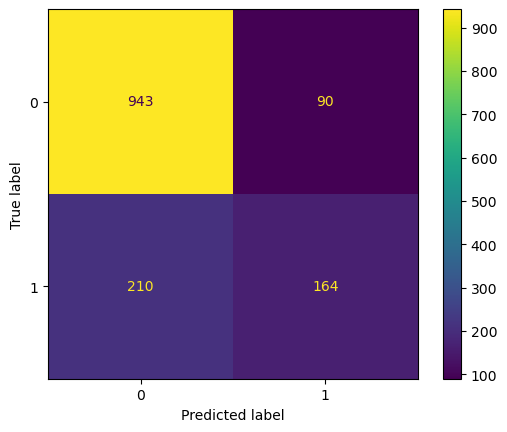

In [28]:
selected_feature_sets = {
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(),
    "selected_features_3": importances.sort_values(by='Gini-importance')[-3:].index.tolist()
}


for feature_set_name in selected_feature_sets.keys():
    feature_set = selected_feature_sets[feature_set_name]
    X = corr_df[feature_set]
    y = corr_df["Churn_Yes"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    fs_mlp_model = MLPClassifier(random_state=1,activation='logistic',alpha=0.05,hidden_layer_sizes=(59,),
                                 learning_rate = 'constant',solver='adam').fit(X_train,y_train)
    
    print(classification_report(y_test, fs_mlp_model.predict(X_test)))
    ConfusionMatrixDisplay.from_estimator(fs_mlp_model,X_test,y_test)
    print(feature_set_name)
    
    

With 10 features we obtain a 79% accuracy, and with ONLY 3 features we also obtain a 79% accuracy, althought the Churn_Yes prediction f1-score is reduced to 52% which is a point of concern and should be taken into account if any decisions are made based off of this model.


# Customer clustering
Clustering performs best when data is exclusively categorical or numerical. Hence for mixed-data clustering, which uses distance metrics, we convert to numerical and scaled data. The assumption here is again that we do not lose significant contextual data loss as a result of this conversion. I intentionally drop the 'Churn' columns to test whether the clustering of customers can provide further insights into who might be at risk of churning.

In [32]:
num_df = pd.get_dummies(df.drop(['customerID','Churn'],axis=1),drop_first=True)
scaler_test = StandardScaler()
std_scaled_df = scaler_test.fit_transform(num_df)


In [33]:
# type: ignore
from sklearn.cluster import KMeans

ssd = []

for k in range(2,30):

    model = KMeans(n_clusters=k)
    model.fit(std_scaled_df)
    ssd.append(model.inertia_)

Text(0, 0.5, ' Sum of Squared Distances')

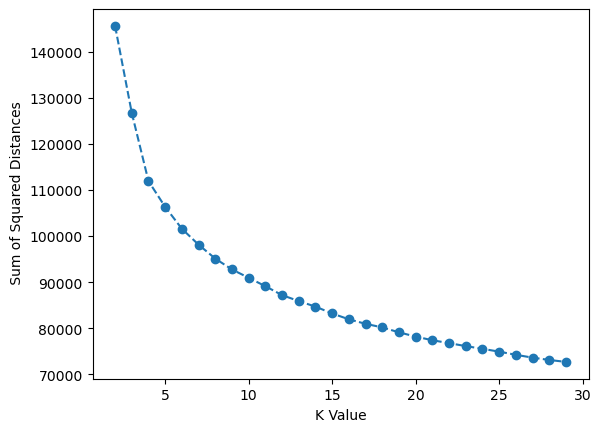

In [34]:
plt.plot(range(2,30),ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances")

<AxesSubplot:>

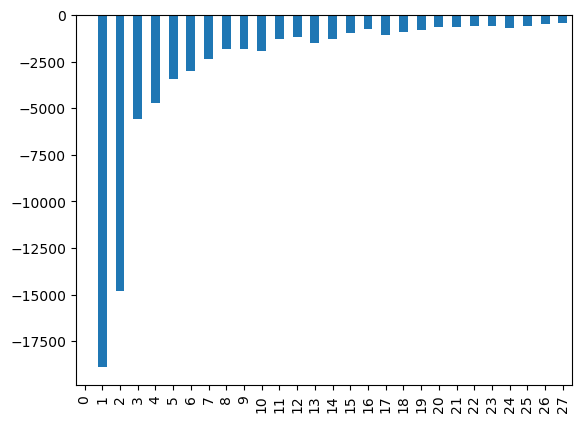

In [35]:
pd.Series(ssd).diff().plot(kind='bar')

Here we see the largest difference occurs between element 2 and 3, hence K=4 provides the steepest change in the SSD (sum of squared distances), a metric used to measure the density of the clusters

# Explore K=4 Clusters

In [36]:
model_k4 = KMeans(n_clusters=4)
model_k4.fit(std_scaled_df);

In [37]:
np.set_printoptions(threshold=np.inf)
model_k4.labels_.shape

(7032,)

In [38]:
df['K=4 Cluster Labels'] = model_k4.labels_

In [40]:
df.corr()['K=4 Cluster Labels'].sort_values()

tenure               -0.645917
TotalCharges         -0.622861
MonthlyCharges       -0.081678
SeniorCitizen         0.069353
K=4 Cluster Labels    1.000000
Name: K=4 Cluster Labels, dtype: float64

In [41]:
num_df['K=4 Cluster Labels'] = model_k4.labels_
num_df.corr()['K=4 Cluster Labels'].sort_values()[:-1]

tenure                                  -0.645917
TotalCharges                            -0.622861
Contract_Two year                       -0.428082
Partner_Yes                             -0.318451
DeviceProtection_Yes                    -0.317880
OnlineBackup_Yes                        -0.279572
Contract_One year                       -0.278804
TechSupport_Yes                         -0.277988
OnlineSecurity_Yes                      -0.244043
MultipleLines_Yes                       -0.242783
OnlineSecurity_No internet service      -0.238273
StreamingMovies_No internet service     -0.238273
InternetService_No                      -0.238273
OnlineBackup_No internet service        -0.238273
DeviceProtection_No internet service    -0.238273
TechSupport_No internet service         -0.238273
StreamingTV_No internet service         -0.238273
StreamingTV_Yes                         -0.235366
StreamingMovies_Yes                     -0.234037
Dependents_Yes                          -0.202414


In [42]:
num_df.corr()['K=4 Cluster Labels'].sort_values()[-6:-1]

SeniorCitizen                     0.069353
PaperlessBilling_Yes              0.095138
InternetService_Fiber optic       0.098165
MultipleLines_No phone service    0.108738
PaymentMethod_Electronic check    0.287452
Name: K=4 Cluster Labels, dtype: float64

In [43]:

top_corr = pd.concat([num_df.corr()['K=4 Cluster Labels'].sort_values()[0:5] , num_df.corr()['K=4 Cluster Labels'].sort_values()[-6:-1]]).sort_values(ascending=False)

In [44]:
plt.figure(figsize=(14,6))
sns.barplot(x= top_corr.index, y= top_corr.values)
plt.xticks(rotation=90);
plt.title('Feature correlation to K=4 Clustering labels')
plt.ylabel('Correlation')

Text(0, 0.5, 'Correlation')

<AxesSubplot:xlabel='tenure', ylabel='TotalCharges'>

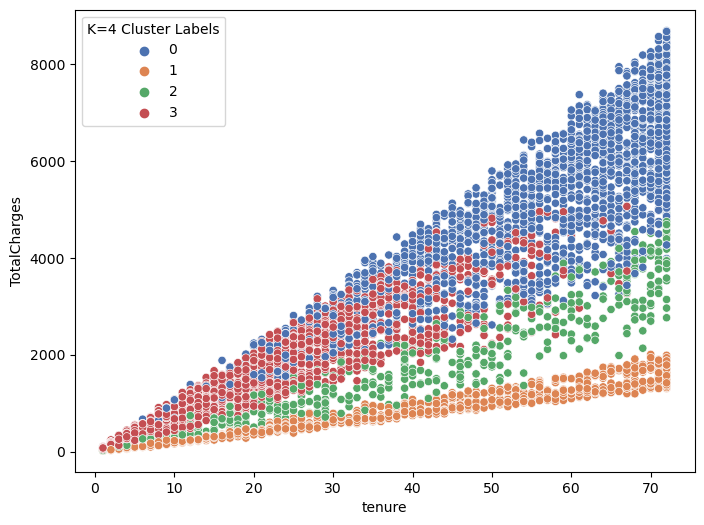

In [45]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='tenure', y='TotalCharges', hue='K=4 Cluster Labels',palette='deep')

<AxesSubplot:xlabel='MonthlyCharges', ylabel='tenure'>

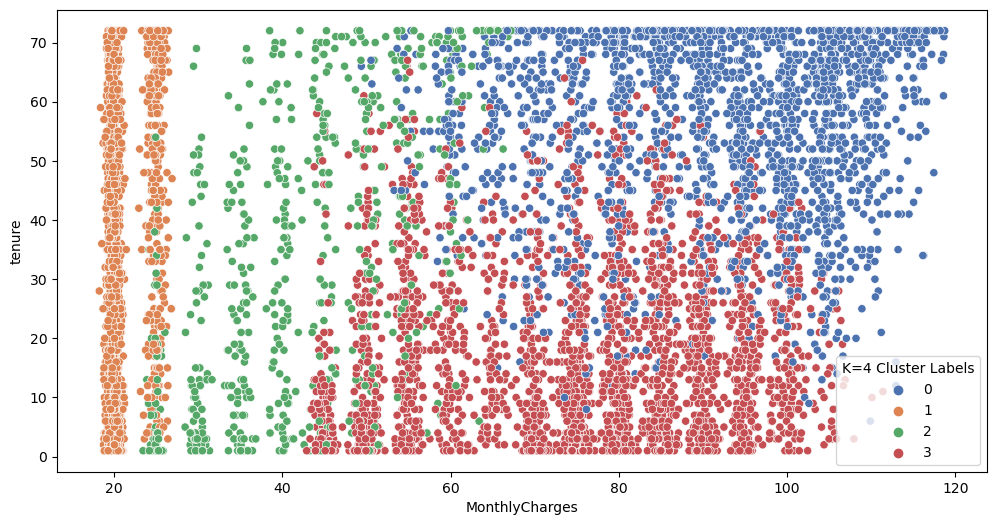

In [46]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=num_df, x='MonthlyCharges', y='tenure', hue=num_df['K=4 Cluster Labels'],palette='deep')

The above visualizations are not clear, as the explainability of the clustering algorithm is not satisfactory. Hence we attempt different type of visuals.

C:\Users\Leonida\AppData\Local\Temp\ipykernel_9488\4020940639.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 800x600 with 0 Axes>

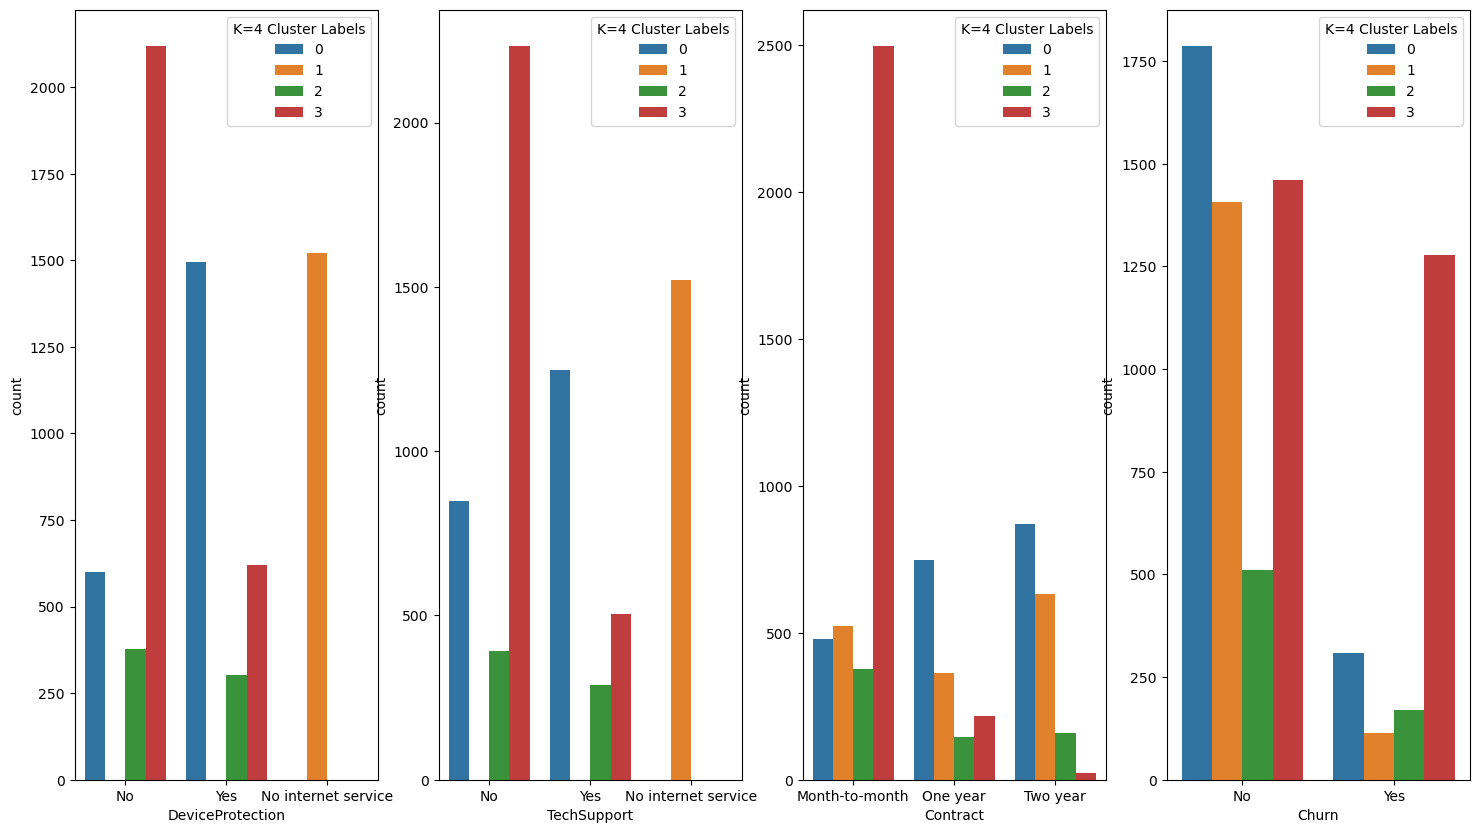

In [47]:
plt.figure(figsize=(8,6))
fig,ax =plt.subplots(1,4,figsize=(18,10))
sns.countplot(x='DeviceProtection',hue='K=4 Cluster Labels',data=df,ax=ax[0])
sns.countplot(x='TechSupport',hue='K=4 Cluster Labels',data=df,ax=ax[1])
sns.countplot(x='Contract',hue='K=4 Cluster Labels',data=df,ax=ax[2])
sns.countplot(x='Churn',hue='K=4 Cluster Labels',data=df,ax=ax[3])
fig.show()

Here we see some clear insights: Cluster 3 has defining characterics such as No DeviceProtection, No TechSupport, Month-to-month Contract and ultimately the largest portion of the Churn Yes group. From this we can build an explainable profile for a marketing/management team to interpret our cluster results. 

We inspect the relationship of cluster labels and churn one step further:

<AxesSubplot:xlabel='K=4 Cluster Labels', ylabel='count'>

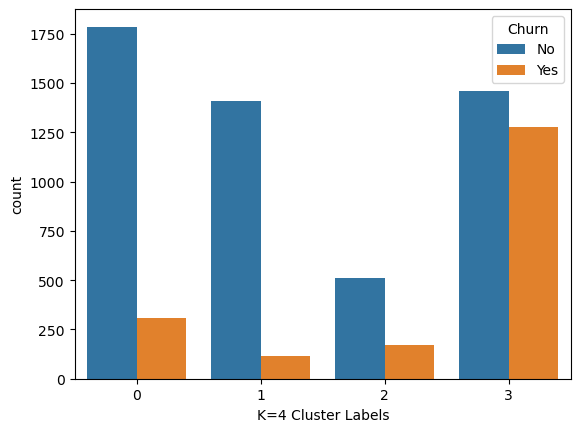

In [48]:
sns.countplot(data=df,x='K=4 Cluster Labels',hue='Churn')

From this we can clearly see Cluster 3 favours the Churn Yes group, even though our clustering algorithm did not use the Churn column in our original dataset. By looking at other characteristics in the same group we can start to identify what type of customer profile fits into cluster 3 if our business requirements demand it.

Even though Cluster 3 has an even distribution of Churn Yes and No customers, it is still significant as it holds the largest relative amount of Churn Yes customers.

# Use Principal Component Analysis to aid in cluster visualization

First explore 2 principal components:

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(std_scaled_df)


In [50]:
np.sum(pca.explained_variance_ratio_)

0.4516919987342475

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Pc 2')

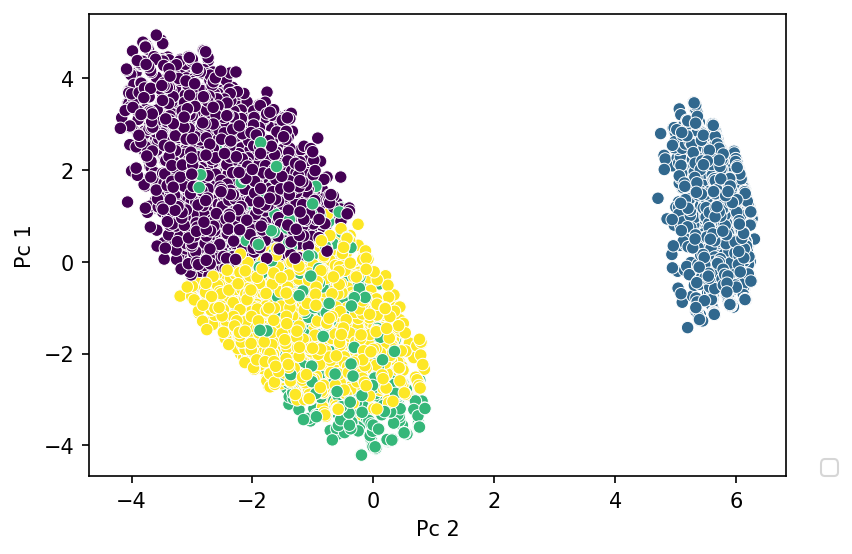

In [51]:
plt.figure(figsize=(6,4),dpi=150)
sns.scatterplot(x=pca_data[0:,0],y=pca_data[0:,1],c=df['K=4 Cluster Labels'].values,cmap='viridis')
plt.legend(loc=(1.05,0))
plt.ylabel('Pc 1')
plt.xlabel('Pc 2')

The 2d visualization of 4 clusters is somewhat unclear, as the 3 of the clusters meld together. Hence we investigate 3 principal components to try and find a better view:

In [52]:
pca3 = PCA(n_components=3)
pca3_data = pca3.fit_transform(std_scaled_df)

In [53]:
np.sum(pca3.explained_variance_ratio_)

0.5418367652220349

The above value tells us that our 3 principal components can explain 54% of the total variance in the dataset. This is a dimensionality reduction technique that can greatly increase efficiency of data processing and predictions, at the cost of interpretability and explainability.

In [54]:
from mpl_toolkits import mplot3d


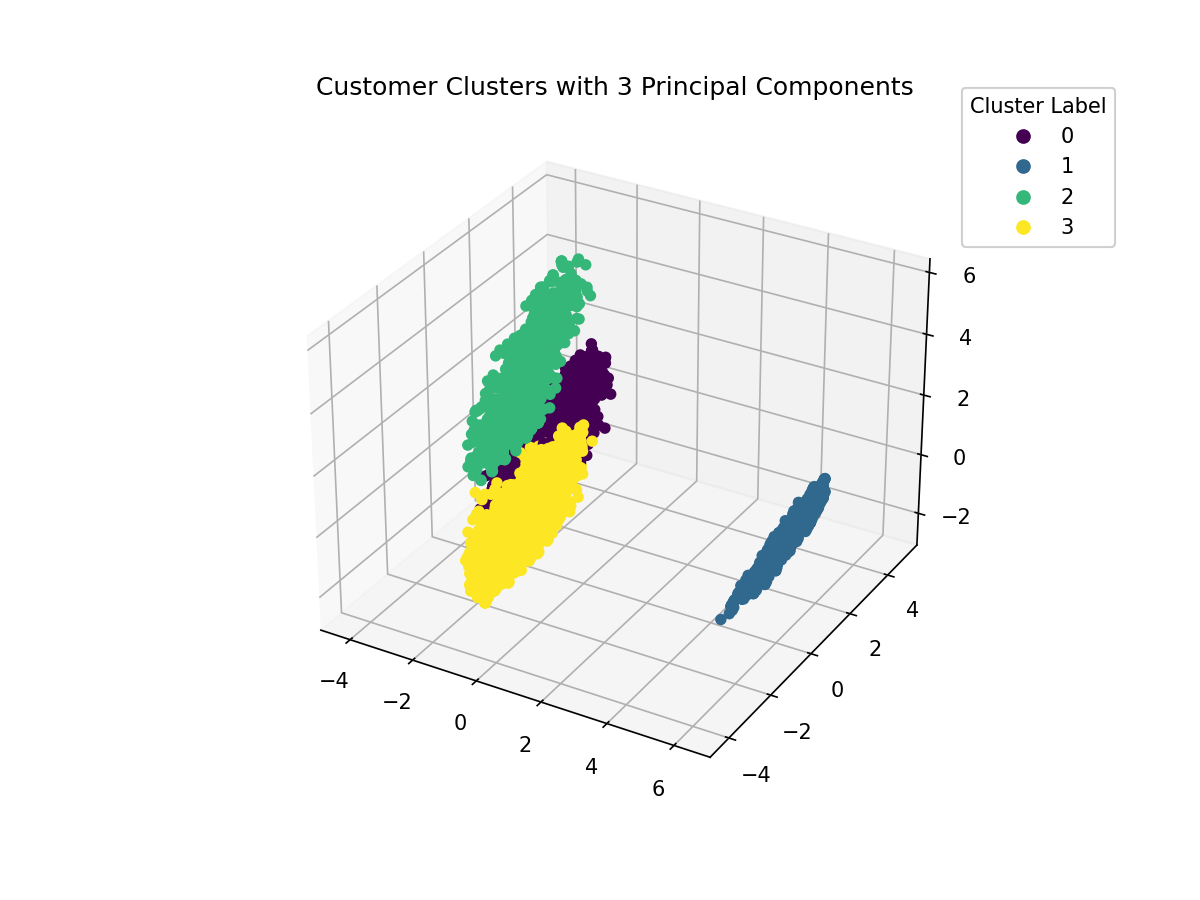

In [55]:
%matplotlib widget

plt.figure(figsize=(8,6),dpi=150)
ax = plt.axes(projection='3d')
scatter = ax.scatter3D(pca3_data[:,0],pca3_data[:,1],pca3_data[:,2],c=df['K=4 Cluster Labels'],linewidth=1,depthshade=False)
ax.set_title('Customer Clusters with 3 Principal Components')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc=(1,0.8), title="Cluster Label")
ax.add_artist(legend1)

plt.show()

As we can see from the above plot, with 3 principal components, we get a clear clustering of customers with the only exception being the boundary between cluster 1 and 2. We can use this information to further investigate the properties and behaviours of each cluster and align this information with specific business requirements to provide value to the marketing or management team. For example, we know that cluster 1 are our high churners, so from this graphic we see there is an unkown similarity boundary with cluster 3. So we may investigate properties of cluster 3 further to stop customers from transitioning from the no churn to the yes churn cluster.